#**Using SHAP to Understand Text Tokens' Effects in a Classifier**

We are going to train a simple text classifier (using our data for the detection of fake reviews). For any given review classification, we can see which terms most contributed to the resulting classification.

#*Load TripAdvisor Reviews*

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

from google.colab import drive

drive.mount('/content/drive')
trip_advisor = pd.read_csv("drive/My Drive/Teaching/Courses/BA 865/BA865-2025/Lecture Materials/Week 4/datasets/deceptive-opinion.csv")

trip_advisor.describe(include='all')

trip_advisor_text = trip_advisor['text'].to_numpy()
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

print(trip_advisor_text)

Mounted at /content/drive
['We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n'
 'Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n'
 "This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear 

#*Define / Train Our Fake Review Detector*

In [ ]:
# Parameters
max_tokens = 1000  # Maximum vocabulary size - just 1000 to keep the SHAP plot simple later...
output_sequence_length = None  # For variable-length multi-hot vectors

# Define the TextVectorization layer
text_vectorization_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='multi_hot',
    output_sequence_length=output_sequence_length
)

text_vectorization_layer.adapt(trip_advisor_text)

trip_advisor_num = text_vectorization_layer(trip_advisor_text)

Note that SHAP requires that the input features be numeric (it can't work with strings). So, the input layer to our model needs to be integer sequences.

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(250, activation="linear"),
        layers.Dense(50, activation="relu",kernel_regularizer="l2"),
        layers.Dense(5, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
    return model

model = build_model()

history = model.fit(trip_advisor_num[:1200], label[:1200], validation_split=0.2, epochs=10, batch_size=25)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6668 - loss: 1.3202 - val_accuracy: 0.9792 - val_loss: 0.6378
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9614 - loss: 0.6432 - val_accuracy: 0.9958 - val_loss: 0.3812
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.4009 - val_accuracy: 0.9542 - val_loss: 0.3201
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.2543 - val_accuracy: 0.9750 - val_loss: 0.2095
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.1728 - val_accuracy: 0.9458 - val_loss: 0.2257
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.1179 - val_accuracy: 0.9583 - val_loss: 0.1781
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0868 - val_accuracy: 0.9625 - val_loss: 0.1307
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0656 - val_accuracy: 0.9500 - val_loss

#*Create Our SHAP Explainer*

In [ ]:
try:
  import shap
except ImportError as error:
  !pip install shap
  import shap

# Use the first 1200 reviews as the basis of calculating shap values for any given prediction instance.
background = trip_advisor_num.numpy().astype(np.int64)

# 'Adapt' the explainer to those reference samples, given our trained predictive model.
# Note that I'm using a GradientExplainer here instead of DeepExplainer, because DeepExplainer breaks with
# my multihot text model for an inexplicable reason.
explainer = shap.GradientExplainer(model, background)

# We will produce shape values for the following observations.
test_obs = trip_advisor_num[1250:]

shap_values = explainer.shap_values(test_obs.numpy().astype(np.int64))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(350, 1000))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 1000))']
  warnings.warn(msg)


Finally, let's create a plot. In this case, a Waterfall plot.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


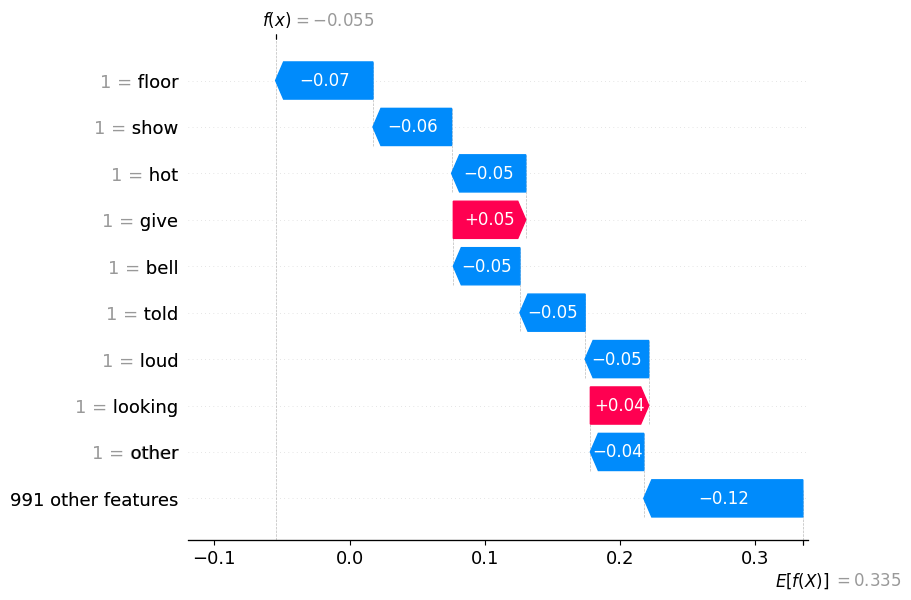

In [ ]:
baseline_output = model.predict(background).mean()

image_index = 3

shap_values_reshaped = shap_values[image_index].reshape(-1)

# Convert shap_values and features to list for serialization
features_list = text_vectorization_layer.get_vocabulary()# Convert terms to list if it's not already

# Use SHAP's force plot to visualize the contribution of each feature
shap.initjs()  # Initialize JavaScript visualization in Jupyter notebooks

shap.waterfall_plot(shap.Explanation(values=shap_values_reshaped,
                                       base_values=baseline_output,
                                       data=test_obs.numpy().astype(np.int64)[image_index],
                                       feature_names=features_list),
                   max_display=10)